In [1]:
from os import environ
environ['train_device'] = 'cuda:2' # training device: 'cpu' or 'cuda:X'
environ['store_device'] = 'cuda:2' # Data storing device:  'cpu' or 'cuda:X'
environ['dataset_file'] = '/data/scratch/mmerouani/processed_datasets/dataset_batch4X_train_val_set.pkl' #training / validation set
environ['test_dataset_file'] = '/data/scratch/mmerouani/processed_datasets/dataset_batch4X_test_set.pkl' #test set
environ['benchmark_dataset_file']='/data/scratch/mmerouani/processed_datasets/dataset_Benchmark_batch10.pkl' #benchmarks set 
#a copy of these datasets can be found in /data/commit/tiramisu/cost-model_datasets/processed_datasets/


%run utils.py # imports and defines some utils functions

### Data loading

In [2]:
train_val_dataset, val_bl, val_indices, train_bl, train_indices = load_data(dataset_file, 0.2,max_batch_size=832)
test_dataset, test_bl, test_indices, _, _ = load_data(test_dataset_file, 1)

loading batches from: /data/scratch/mmerouani/processed_datasets/dataset_batch4X_train_val_set.pkl


100%|██████████| 46640/46640 [26:40<00:00, 29.13it/s]


GPU memory on cuda:2 nearly full, switching to CPU memory
Number of batches 1930
Data loaded
Sizes: (386, 1544) batches
loading batches from: /data/scratch/mmerouani/processed_datasets/dataset_batch4X_test_set.pkl


100%|██████████| 8502/8502 [05:09<00:00, 27.44it/s]


GPU memory on cuda:2 nearly full, switching to CPU memory
Number of batches 253
Data loaded
Sizes: (253, 0) batches


### Model definition 

In [3]:
input_size = 2534

model = None 

model = Model_Recursive_LSTM_v2(input_size,drops=[0.112, 0.112, 0.112, 0.112])
model.to(train_device)

criterion = mape_criterion

optimizer = AdamW(model.parameters(),weight_decay=0.375e-2)    
    

### Model training

In [5]:
bl_dict={'train':train_bl, 'val':val_bl}
log_file = 'log_Recursive_LSTM_v2.txt'

losses, best_model = train_model(model, criterion, optimizer , max_lr=0.001, dataloader=bl_dict,
                                 num_epochs=800, logFile=log_file, log_every=1)

Epoch 1/800:  train Loss: 85.3366   val Loss: 81.7021   time: 30.68s   best: 81.7021
Epoch 2/800:  train Loss: 80.2573   val Loss: 75.8455   time: 23.93s   best: 75.8455
Epoch 3/800:  train Loss: 76.7990   val Loss: 72.1598   time: 24.36s   best: 72.1598
Epoch 4/800:  train Loss: 74.6296   val Loss: 70.9524   time: 23.36s   best: 70.9524
Epoch 5/800:  train Loss: 73.5082   val Loss: 70.6836   time: 23.76s   best: 70.6836
Epoch 6/800:  train Loss: 72.5218   val Loss: 70.7238   time: 23.79s   best: 70.6836
Epoch 7/800:  train Loss: 71.8005   val Loss: 69.4570   time: 25.18s   best: 69.4570
Epoch 8/800:  train Loss: 70.9460   val Loss: 68.2762   time: 26.06s   best: 68.2762
Epoch 9/800:  train Loss: 69.3416   val Loss: 64.1731   time: 23.74s   best: 64.1731
Epoch 10/800:  train Loss: 67.0098   val Loss: 61.7273   time: 23.98s   best: 61.7273
...
...
...
Epoch 109/800:  train Loss: 26.3896   val Loss: 24.3845   time: 25.84s   best: 23.6946
Epoch 110/800:  train Loss: 26.3453   val Loss: 23

KeyboardInterrupt: 

### Loading a pre-trained model

In [6]:
model.load_state_dict(torch.load('Recursive_LSTM_v2_16.32.pkl',map_location=train_device))
model.to(train_device)
print()

### Basic results on the test and validation set

In [8]:
val_df = get_results_df(train_val_dataset, val_bl, val_indices, model)
test_df = get_results_df(test_dataset, test_bl, test_indices, model)


100%|██████████| 253/253 [00:06<00:00, 36.35it/s]


In [8]:
test_df.describe()

,exec_time,prediction,target,abs_diff,APE
count,276017.000000,276017.000000,276017.000000,276017.000000,276017.000000
mean,577.834388,1.238106,1.344900,0.249253,16.320051
std,1349.081196,2.302294,2.850899,1.143897,32.189922
min,0.008000,0.001574,0.001865,0.000000,0.000000
25%,31.966000,0.349922,0.370004,0.017328,3.809805
50%,142.772500,0.821265,0.834172,0.059552,10.242489
75%,500.436500,1.011100,1.102495,0.165281,20.954794
max,30174.302000,26.906061,99.264748,72.367393,2669.392578


In [9]:
val_df.describe()

,exec_time,prediction,target,abs_diff,APE
count,299387.000000,299387.000000,299387.000000,299387.000000,299387.000000
mean,571.996887,1.234157,1.345729,0.223093,12.983403
std,1315.995884,2.357585,3.006141,1.238141,14.970219
min,0.013000,0.001042,0.001400,0.000000,0.000000
25%,32.825500,0.346737,0.369616,0.013997,3.175231
50%,147.170000,0.810723,0.824883,0.048328,8.397388
75%,494.729500,1.004372,1.081886,0.138263,17.388187
max,27927.257500,26.906689,108.446342,81.591415,335.025208


In [10]:
test_df[(test_df['exec_time']*test_df['target'])>5].describe()

,exec_time,prediction,target,abs_diff,APE
count,236110.000000,236110.000000,236110.000000,236110.000000,236110.000000
mean,674.690589,1.209179,1.313958,0.241153,14.795569
std,1436.207752,2.371653,2.962423,1.207506,18.628445
min,0.159000,0.002081,0.004130,0.000000,0.000000
25%,58.973000,0.352329,0.371583,0.015834,3.527706
50%,198.297000,0.827683,0.834337,0.054322,9.576809
75%,626.946625,1.001174,1.061528,0.148256,19.524477
max,30174.302000,26.906061,99.264748,72.367393,660.251038


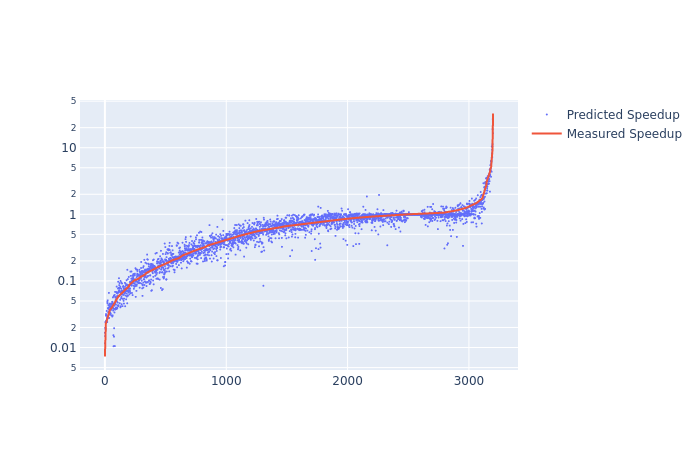

In [11]:
sample_size = 3200

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(sample_size)), y=test_df.iloc[:sample_size].sort_values(by=['target'])['prediction'],
                    mode='markers', name='Predicted Speedup',marker=dict( size=2)))
fig.add_trace(go.Scatter(x=list(range(sample_size)), y=test_df.iloc[:sample_size].sort_values(by=['target'])['target'],
                    mode='lines', name='Measured Speedup' ))

fig.update_yaxes(type="log")
fig.show('png') # use fig.show() for interactive mode

### Basic results on the benchmark set

In [11]:
benchmark_dataset, benchmark_bl, benchmark_indices, _, _ = load_data(benchmark_dataset_file, 1)

loading batches from: /data/scratch/mmerouani/processed_datasets/dataset_Benchmark_batch10.pkl


100%|██████████| 3490/3490 [06:51<00:00,  8.49it/s] 


GPU memory on cuda:1 nearly full, switching to CPU memory
Number of batches 209
Data loaded
Sizes: (209, 0) batches


In [12]:
benchmark_df = get_results_df(benchmark_dataset, benchmark_bl, benchmark_indices, model)

100%|██████████| 209/209 [00:04<00:00, 46.89it/s]


In [13]:
benchmark_df.describe()

,exec_time,prediction,target,abs_diff,APE
count,421970.000000,421970.000000,421970.000000,421970.000000,421970.000000
mean,278.649851,0.783475,0.880940,0.324966,37.383327
std,782.865651,1.153458,1.581883,1.013817,108.208588
min,0.000500,0.004219,0.002237,0.000000,0.000000
25%,0.939500,0.152988,0.159301,0.020883,8.126566
50%,32.206250,0.462187,0.470533,0.069968,19.862350
75%,191.909875,0.952370,0.926913,0.210568,40.264337
max,19474.926000,22.491194,77.500000,76.347122,11199.112305
